Pure Oxygen Model (Chapman reactions)

(Note: althouth HOx accounts for >90% and Ox accouts for <5% of the O3 destruction in the mesosphere, we are here looking at the dependency of [O] profile on Ly-a, thus a simple Chapman scheme is enough to see the relative difference made, rather than the absolute values.)

O2 -->(J_O2) O + O

O3 -->(J_O3) O + O2

O + O + M --(k1) O2 + M  Barth

O + O2 + M -->(k2) O3 + M

O + O3 -->(k3) O2 + O2

Steady state equation

[O] = (2*J_O2[O2] + J_O3[O3])/(k2[M][O2] + k3[O3])

or with the Barth reaction

a = - 2*k1[M]

b = - (k2[M][O2] + k3[O3])

c = 2*J_O2[O2] + J_O3[O3]

[O] = (-b - sqrt(b^2 - 4ac)) / (2a)


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
clima = xr.open_dataset('/home/anqil/Documents/Python/external_data/msis_cmam_climatology_z200_lat8576.nc')
z = clima.z.sel(z=slice(50,150,1))
sel_clima_args = dict(month=12, lat=0, z=z, method='nearest')
T = clima.sel(**sel_clima_args).T
p = clima.sel(**sel_clima_args).plev
o2 = clima.sel(**sel_clima_args).o2*1e-6 #cm-3
n2 = clima.sel(**sel_clima_args).n2*1e-6 #cm-3
m = o2+n2 #cm-3
o3 = clima.sel(**sel_clima_args, lst=17).o3_vmr * m.rename('o3') #cm-3
# o3.plot(y='z', xscale='log')

In [5]:
def path_z (z_top, z_t, sol_zen, nsteps):
    if sol_zen == 0:
        z_step = np.linspace(z_top, z_t, nsteps)
        step = (z_top - z_t)/nsteps
    elif sol_zen == 180:
        z_step = np.zeros(nsteps)
        step = 0
    else:     
        Re = 6375 #km (should be the same unit as z)
        sol_zen /= 180/np.pi
        B=np.arcsin((Re+z_t) * np.sin(np.pi-sol_zen)/(Re+z_top))
        S_top=np.sin(sol_zen-B)*(Re+z_top)/np.sin(np.pi-sol_zen)

        Ret2=(Re + z_t)**2
        step=S_top/nsteps
        S_top_half= S_top - step/2
        z_step=[np.sqrt(Ret2 +(S_top_half - i*step)**2 -
                        2*(Re + z_t)*(S_top_half - 
                          i*step)*np.cos(np.pi-sol_zen))-Re for i in range(nsteps) ]
        z_step = np.array(z_step)
    #check the Earth's shadow
    if (z_step<0).any():
        z_step = np.zeros(nsteps)    
    return(z_step, step)

def photolysis(z, sol_zen, density_lst, xs_lst, name_lst, irrad, wavelength):
    #z in km
    #density in cm-3
    #xs (cross section) in cm2
    j_lst = [[] for i in range(len(density_lst))]
    # j_sum_lst = [[] for i in range(len(density_lst))]
    for z_t in z:
        z_paths, path_step= path_z(z[-1],z_t,sol_zen,100)
        attenuation_coeff = [xs * (np.exp(np.interp(z_paths, z, np.log(density)))).sum()  #sum over z_paths
                               for xs, density in zip(xs_lst, density_lst)]
        tau = np.sum(attenuation_coeff, axis=0) * path_step *1e5 #km-->cm , sum over species   
        j_z_lst = (irrad * xs_lst * np.exp(-tau)) #
        [j.append(j_z) for j,j_z in zip(j_lst, j_z_lst)]
        # [j_sum.append(j_z.sum()) for j_sum,j_z in zip(j_sum_lst, j_z_lst)] #sum over wavelength
    
    data_j = {'j{}'.format(name): (('z', 'wavelength'), j) for name,j in zip(name_lst, j_lst)}
    # data_j_sum = {'j{}_sum'.format(name): (('z',), j_sum) for name,j_sum in zip(name_lst, j_sum_lst)}

    return xr.Dataset({'z': (('z',), z),
                       'wavelength': (('wavelength',), wavelength),
                       **data_j, 
                    #    **data_j_sum,
                       })


In [6]:
month = o3.month.item()
lat = o3.lat.item()
lst = o3.lst.item()
hour = int(lst)
min = abs(int((lst-hour)*60))
sec = (abs((lst-hour)*60)-min)*60

import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
loc = coord.EarthLocation(lon=0 * u.deg,
                          lat=lat * u.deg)
now = Time('2001-{}-01 {}:{}:{}'.format(month, hour, min, sec))
altaz = coord.AltAz(location=loc, obstime=now)
sun = coord.get_sun(now)
sol_zen = sun.transform_to(altaz).zen.deg
sol_zen

83.13187418754258

In [7]:
ds_xs = xr.open_dataset('/home/anqil/Documents/Python/Photochemistry/xs_anqi.nc')
wavelength = ds_xs.wavelength
so2 = ds_xs.so2
so3 = ds_xs.so3
irrad = ds_xs.irrad

#remove duplicated wavelength in the xs file
so2 = so2[1:].where(wavelength.diff('wavelength')!=0, drop=True)
so3 = so3[1:].where(wavelength.diff('wavelength')!=0, drop=True)
irrad = irrad[1:].where(wavelength.diff('wavelength')!=0, drop=True)
wavelength = wavelength[1:].where(wavelength.diff('wavelength')!=0, drop=True)

Js = photolysis(
    z=z.values, 
    sol_zen=sol_zen, 
    density_lst=(o2.values, o3.values), 
    xs_lst=(so2.values, so3.values), 
    name_lst=('o2', 'o3'),
    irrad=irrad.values,
    wavelength=wavelength.values,
    )
Js

<xarray.Dataset>
Dimensions:     (wavelength: 221, z: 101)
Coordinates:
  * z           (z) int64 50 51 52 53 54 55 56 ... 144 145 146 147 148 149 150
  * wavelength  (wavelength) float64 12.5 17.5 22.5 27.5 ... 840.0 845.0 850.0
Data variables:
    jo2         (z, wavelength) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    jo3         (z, wavelength) float64 0.0 0.0 0.0 ... 2.968e-07 2.972e-07

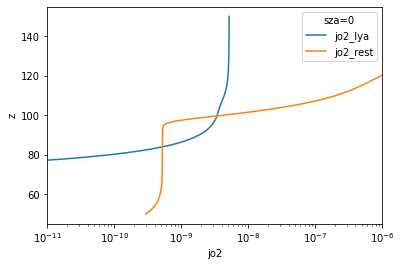

In [8]:
Js.jo2.sel(wavelength=slice(121.55,121.65)).sum('wavelength').plot(y='z',label='jo2_lya')
(Js.jo2.sum('wavelength') - Js.jo2.sel(wavelength=slice(121.55,121.65)).sum('wavelength')).plot(y='z', label='jo2_rest')
plt.legend(title='sza={}'.format(0))
plt.xscale('log')
plt.xlim(1e-11,1e-6)
# plt.ylim(30,100)
plt.show()

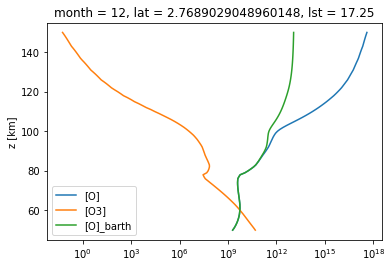

In [9]:
def o_profile(o2, o3, m, jo2_lya, jo2_rest, jo3, k2, k3): #chapman reactions in equilibrium state
    return (2*(jo2_lya + jo2_rest)*o2 + jo3*o3)/(k2*m*o2 + k3*o3)

def o_barth_profile(o2, o3, m, jo2_lya, jo2_rest, jo3, k1, k2, k3): #include Barth mechanism
    a = - 2*k1*m # O+O+M
    b = - k2*m*o2 - k3*o3 #O+O2+M, O+O3
    c = 2*(jo2_lya + jo2_rest)*o2 + jo3*o3 #O2+hv, O3+hv
    return (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    # result = []
    # for zi in o2.z:
    #     result.append(np.roots([a.sel(z=zi), b.sel(z=zi), c.sel(z=zi)])[1])
    # return xr.DataArray(result, dims=('z',), coords=(o2.z,))

jo2_lya = Js.jo2.sel(wavelength=slice(121.55,121.6)).sum('wavelength')
jo2_rest = Js.jo2.sum('wavelength') - jo2_lya
jo3 = Js.jo3.sum('wavelength')
k1 = 9.59e-34*np.exp(480/T) #O+O+M Allen 1984 
k2 = 6e-34*(300/T)**2.4 #O+O2+M Marsh(2006) Page 11 
k3 = 1.5e-11*np.exp(-2218/T) #O+O3 Allen 1984 #8e-12*np.exp(-2060/T) #S&B appendix 

o = o_profile(o2, o3, m, jo2_lya, jo2_rest, jo3, k2, k3)
o_barth = o_barth_profile(o2, o3, m, jo2_lya, jo2_rest, jo3, k1, k2, k3)
o.plot(y='z', xscale='log', label='[O]')
o3.plot(y='z', xscale='log', label='[O3]')
o_barth.plot(y='z', xscale='log', label='[O]_barth')

plt.legend()
plt.show()

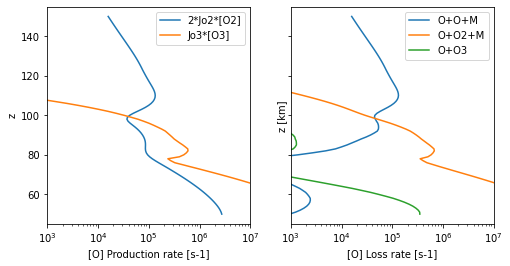

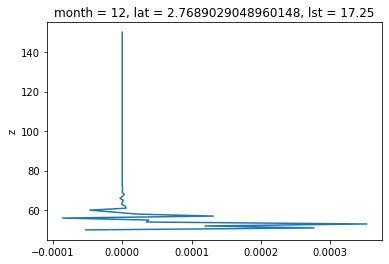

In [ ]:
P_1 = 2*(Js.jo2.sum('wavelength')*o2) # o2 photolysis
P_2 = (Js.jo3.sum('wavelength')*o3) # o3 photolysis
L_1 = 2*(k1*o_barth**2*m) #O+O+M
L_2 = (k2*o_barth*o2*m) #O+O2+M
L_3 = (k3*o_barth*o3) #O+O3
fig, ax = plt.subplots(1,2, figsize=(8,4), sharey=True)
plot_args = dict(y='z', xscale='log')
P_1.plot(ax=ax[0], label='2*Jo2*[O2]', **plot_args)
P_2.plot(ax=ax[0], label='Jo3*[O3]', **plot_args)
L_1.plot(ax=ax[1], label='O+O+M', **plot_args)
L_2.plot(ax=ax[1], label='O+O2+M', **plot_args)
L_3.plot(ax=ax[1], label='O+O3', **plot_args)
ax[0].set(title='', xlabel='[O] Production rate [cm-3 s-1]', xlim=(1e3, 1e7))
ax[1].set(title='', xlabel='[O] Loss rate [cm-3 s-1]', xlim=(1e3, 1e7))
[ax[i].legend() for i in range(len(ax))]
plt.show()

(P_1+P_2-L_1-L_2-L_3).plot(y='z', xscale='linear')

Q: Why does [O] profile not like a layer profile?

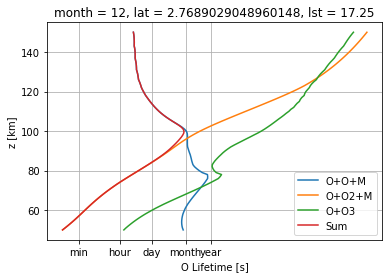

In [ ]:
# [O] lifetimes
tau_1 = 1/(2*k1*o*m)
tau_2 = 1/(k2*o2*m)
tau_3 = 1/(k3*o3)
tau_tot = 1/(2*k1*o*m+k2*o2*m+k3*o3)
tau_1.plot(label='O+O+M', y='z')
tau_2.plot(label='O+O2+M', y='z', xscale='log')
tau_3.plot(label='O+O3', y='z')
tau_tot.plot(label='Sum', y='z')
plt.xlabel('O Lifetime [s]')
plt.legend()
plt.xticks([60, 3600, 3600*24, 3600*24*30, 3600*24*30*12], ['min', 'hour', 'day', 'month', 'year'])
plt.grid()
plt.show()

Q: (above 70km, O lifetime is larger than 1 hour. The time near the sunset might not be good to use steady state approximation?)

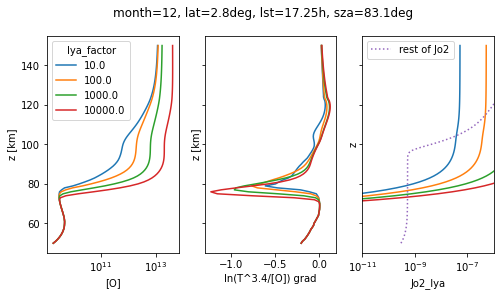

In [ ]:
fig, ax = plt.subplots(1,3,sharey=True, figsize=(8,4))
for factor in np.logspace(1, 4, 4):
    # o = o_profile(o2, o3, m, jo2_lya*factor, jo2_rest, jo3, k2, k3).rename('[O]')
    o = o_barth_profile(o2, o3, m, jo2_lya*factor, jo2_rest, jo3, k1, k2, k3).rename('[O]')
    o.plot(ax=ax[0], y='z', xscale='log', label=factor, )
    (T**3.4/o).pipe(np.log).differentiate('z').rename('ln(T^3.4/[O]) grad').plot(ax=ax[1], y='z', )
    (jo2_lya*factor).plot(ax=ax[2], y='z', xscale='log', xlim=(1e-11, 1e-6))
jo2_rest.plot(ax=ax[2], y='z', ls=':', label='rest of Jo2')
ax[0].legend(title='lya_factor')
ax[2].legend()
ax[2].set_xlabel('Jo2_lya')
plt.suptitle('month={}, lat={}deg, lst={}h, sza={}deg'.format(month, round(lat, 1), lst, round(sol_zen,1)))
[ax[i].set_title('') for i in range(len(ax))]
plt.show()


# Model nighttime OH

One-step convert [O] day to night

/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


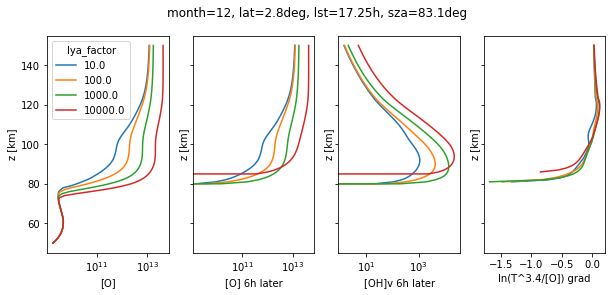

In [ ]:
fig, ax = plt.subplots(1,4,sharey=True, figsize=(10,4))
plot_args = dict(y='z', xscale='log')
for factor in np.logspace(1, 4, 4):
    # o = o_profile(o2, o3, m, jo2_lya*factor, jo2_rest, jo3, k2, k3).rename('[O]')
    o = o_barth_profile(o2, o3, m, jo2_lya*factor, jo2_rest, jo3, k1, k2, k3).rename('[O]')
    o.plot(ax=ax[0], label=factor, **plot_args)
    #nighttime O and OH
    t = 6*3600 #s
    L1 = 2*k1*o*m #s-1 loss rate
    L2 = k2*o2*m
    L3 = k3*o3
    o_night = o - t*(L1+L2+L3)*o 
    ohv_night = p * o_night/ T**3.4
    
    o_night.rename('[O] 6h later').plot(ax=ax[1], **plot_args)
    ohv_night.rename('[OH]v 6h later').plot(ax=ax[2], **plot_args)
    (T**3.4/o_night).pipe(np.log).differentiate('z').rename('ln(T^3.4/[O]) grad').plot(ax=ax[3], y='z', )

ax[0].legend(title='lya_factor')
ax[1].set_xlim(ax[0].get_xlim())
plt.suptitle('month={}, lat={}deg, lst={}h, sza={}deg'.format(month, round(lat, 1), lst, round(sol_zen,1)))
[ax[i].set_title('') for i in range(len(ax))]
plt.show()


Multi-steps convert [O] day to night 

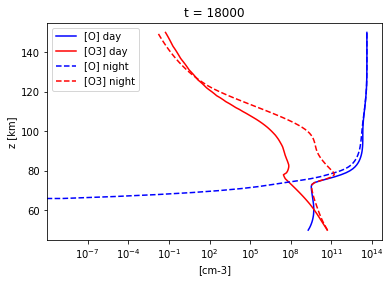

In [ ]:
from scipy.integrate import odeint
def dydt(y, t, o2, m, k2, k3):
    o, o3 = y
    do_dt = -(k2*o2*m + k3*o3) * o #+jo2*o3 + jo3*o3
    do3_dt = k2*o*o2*m - k3*o*o3 # -jo3
    return do_dt, do3_dt

def dydt_barth(y, t, o2, m, k1, k2, k3):
    o, o3 = y
    do_dt = -(2*k1*o*m + k2*o2*m + k3*o3) * o #+jo2*o3 + jo3*o3
    do3_dt = k2*o*o2*m - k3*o*o3 # -jo3
    return do_dt, do3_dt

t = np.arange(0, 6*3600, 3600)
solution = []
for zi in z:
    o_z = o.sel(z=zi).item()
    o3_z = o3.sel(z=zi).item()
    o2_z = o2.sel(z=zi).item()
    m_z = m.sel(z=zi).item()
    k1_z = k1.sel(z=zi).item()
    k2_z = k2.sel(z=zi).item()
    k3_z = k3.sel(z=zi).item()
    solution.append(odeint(func=dydt_barth, 
        y0=[o_z,o3_z], 
        t=t, 
        args=(o2_z, m_z, k1_z, k2_z, k3_z)))

solution = np.stack(solution)
o_z_t = solution[:,:,0]
o3_z_t = solution[:,:,1]
ds = xr.Dataset({'o': (('z', 't'), o_z_t),
                'o3': (('z', 't'), o3_z_t),
                't': t,
                'z': z})
ds.o.isel(t=0).plot.line(y='z', label='[O] day', color='b', ls='-', xscale='log')
ds.o3.isel(t=0).plot.line(y='z', label='[O3] day', color='r', ls='-')
ds.o.isel(t=-1).plot.line(y='z', label='[O] night', color='b', ls='--')
ds.o3.isel(t=-1).plot.line(y='z', label='[O3] night', color='r', ls='--')
plt.legend()
plt.xlabel('[cm-3]')
# plt.xlim(1e7, 1e12) #to match S&B Fig 5.4
# plt.ylim(50, 110)
plt.show()

/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/anqil/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/anqil/anaconda3/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


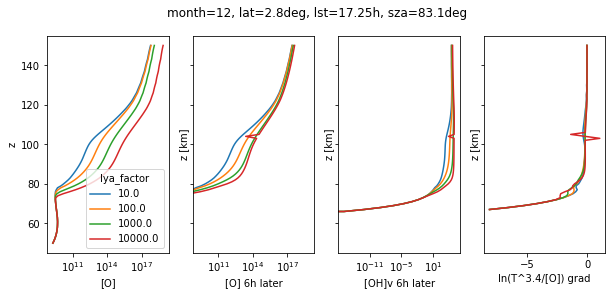

In [ ]:
def day2night(o_day, o3_day, t=np.arange(0,6*3600,3600)):
    o = o_day.copy()
    o3 = o3_day.copy()
    solution = []
    for zi in z:
        o_z = o.sel(z=zi).item()
        o3_z = o3.sel(z=zi).item()
        o2_z = o2.sel(z=zi).item()
        m_z = m.sel(z=zi).item()
        k1_z = k1.sel(z=zi).item()
        k2_z = k2.sel(z=zi).item()
        k3_z = k3.sel(z=zi).item()
        solution.append(odeint(func=dydt_barth, 
            y0=[o_z,o3_z], 
            t=t, 
            args=(o2_z, m_z, k1_z, k2_z, k3_z)))
    solution = np.stack(solution)
    o_night = xr.DataArray(solution[:,-1, 0], dims=('z',), coords=(z,), name='[O]')
    o3_night = xr.DataArray(solution[:,-1, 1], dims=('z',), coords=(z,), name='[O3]')
    return o_night, o3_night

fig, ax = plt.subplots(1,4,sharey=True, figsize=(10,4))
plot_args = dict(y='z', xscale='log')
for factor in np.logspace(1, 4, 4):
    o = o_profile(o2, o3, m, jo2_lya*factor, jo2_rest, jo3, k2, k3).rename('[O]')
    o.plot(ax=ax[0], label=factor, **plot_args)
    #nighttime O and OH
    o_night, _ = day2night(o, o3, t=np.arange(0,3600*6, 3600))
    ohv_night = p * o_night/ T**3.4
    
    o_night.rename('[O] 6h later').plot(ax=ax[1], **plot_args)
    ohv_night.rename('[OH]v 6h later').plot(ax=ax[2], **plot_args)
    (T**3.4/o_night).pipe(np.log).differentiate('z').rename('ln(T^3.4/[O]) grad').plot(ax=ax[3], y='z')

ax[0].legend(title='lya_factor')
ax[1].set_xlim(ax[0].get_xlim())
plt.suptitle('month={}, lat={}deg, lst={}h, sza={}deg'.format(month, round(lat, 1), lst, round(sol_zen,1)))
[ax[i].set_title('') for i in range(len(ax))]
plt.show()


Negative values of [O] below 80km, but better than the one-step day-night convertion. 